In [1]:
import math
import numpy as np
import numpy.random as npr
from numpy import linalg
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils import data
from torch.utils.data import Dataset
import torch.optim as optim
import time
from math import *
torch.cuda.set_device(0)

In [2]:
class ResNet(nn.Module):
    def __init__(self,dim, m,o):
        super(ResNet, self).__init__()
        self.Ix = torch.zeros([dim,m]).cuda()
        self.Ix[0,0] = 1
        self.Ix[1,1] = 1
        self.fc1 = nn.Linear(dim, m)
        self.fc2 = nn.Linear(m, m)
        
        self.fc3 = nn.Linear(m, m)
        self.fc4 = nn.Linear(m, m)

        
        self.outlayer = nn.Linear(m, o)

    def forward(self, x):
        s = x@self.Ix
        y = self.fc1(x)
        y = F.relu(y**deg)
        y = self.fc2(y)
        y = F.relu(y**deg)
        y = y+s
        
        s=y
        y = self.fc3(y)
        y = F.relu(y**deg)
        y = self.fc4(y)
        y = F.relu(y**deg)
        y = y+s
        
        
        output = self.outlayer(y)
        return output
deg = 2

In [3]:
def sol_exact(x):
    return torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
def sol_exact_H1(x):
    sol = torch.zeros(x.shape[0],3).cuda()
    sol[:,0:1] = torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    sol[:,1:3] = pi*torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)
    return sol

In [4]:
def right(x):
    return -2*pi**2*torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [5]:
dim_set = 2
Batch_size = 10000
def DGM1():
    x = torch.rand(Batch_size,2).cuda()
    x.requires_grad = True
    u = model_u(x)
    du = model_p(x)
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    loss1 = torch.sum((ux-du)**2)/Batch_size
    return loss1

In [6]:
dim_set = 2
Batch_size = 10000
def DGM1():
    x = torch.rand(Batch_size,dim_set).cuda()
    x.requires_grad = True
    r1 = model_r1(x)
    r2 = model_r2(x)
    u =  torch.sum((model_r1(x)+model_r2(x))/2,dim = 1).reshape(x.shape[0],1)/dim_set
    du = (model_r1(x)-model_r2(x))/2
    v= torch.ones(u.shape).cuda()
    v= torch.ones(u.shape).cuda()
    ux = torch.autograd.grad(u,x,grad_outputs=v,create_graph=True)[0]
    uxx = torch.zeros(Batch_size,dim_set).cuda()
    for i in range(dim_set):
        ux_tem = du[:,i].reshape([x.size()[0],1])
        uxx_tem = torch.autograd.grad(ux_tem,x,grad_outputs=v,create_graph=True)[0]
        uxx[:,i] = uxx_tem[:,i]
    loss1 = torch.sum((torch.sum(uxx,dim=1).reshape([x.size()[0],1]) - right(x))**2)/Batch_size
    loss1 = loss1 + torch.sum((ux-du)**2)/Batch_size
    loss1 = loss1 + torch.sum((u + du - r1)**2)/Batch_size + torch.sum((u - du - r2)**2)/Batch_size
    return loss1

In [7]:
model_r_2 = ResNet(dim_set,5,dim_set)
model_r_1 = ResNet(dim_set,5,dim_set)

device=torch.device("cuda:0" )
model_r_2.to(device)
model_r_1.to(device)

ResNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=5, bias=True)
  (outlayer): Linear(in_features=5, out_features=2, bias=True)
)

In [8]:
def model_r1(x):
    return (1-x)*model_r_1(x) + torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1) + pi * torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [9]:
def model_r2(x):
    return x*model_r_2(x) + torch.sin(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1) - pi * torch.cos(pi*torch.sum(x,dim = 1)).reshape(x.shape[0],1)

In [10]:
def model_p(x):
    return (model_r1(x)-model_r2(x))/2

In [11]:
def model_u(x):
    return torch.sum((model_r1(x)+model_r2(x))/2,dim = 1).reshape(x.shape[0],1)/dim_set

In [12]:
def loss_error():
    notes_error = torch.rand(10000,dim_set).cuda()
    notes_error.requires_grad= True
    exact = sol_exact_H1(notes_error)
    u_L2 = sqrt(torch.sum((exact[:,0])**2)/10000)
    Du_L2 = sqrt(torch.sum(exact[:,1:dim_set+1]**2)/10000)
    predict = torch.zeros(10000,2*dim_set+2).cuda()
    predict[:,0]= model_u(notes_error).reshape([1,notes_error.size()[0]])
    predict[:,1:dim_set+1]= model_p(notes_error)
    value1 = sqrt(torch.sum((predict[:,0] - exact[:,0])**2)/10000)/u_L2
    value2 = sqrt(torch.sum((predict[:,1:dim_set+1] - exact[:,1:dim_set+1])**2)/10000)/Du_L2
    return value1,value2

In [13]:
traintime = 20000
error_save=np.zeros([2,traintime])
optimizer = optim.Adam([
                {'params': model_r_1.parameters()},
                {'params': model_r_2.parameters()}
            ])
i = 0
time_start=time.time()
for i in range(traintime):
    optimizer.zero_grad()
    losses = DGM1()
    losses.backward()
    optimizer.step() 
    error1,error2 = loss_error()
    error_save[0,i]=float(error1)
    error_save[1,i]=float(error2)
    i = i +1
    if i%500==1:
        print("i= ",i)
        print("error =",error1)
        print("loss1 =",losses.detach())
        np.save("error_save_LDG_Robin_2D_w5.npy", error_save)
np.save("error_save_LDG_Robin_2D_w5.npy", error_save)
time_end=time.time()
print('time cost',time_end-time_start,'s')

i=  1
error = 0.10319965527055389
loss1 = tensor(0.2618, device='cuda:0')
i=  501
error = 0.003058010725341784
loss1 = tensor(0.0007, device='cuda:0')
i=  1001
error = 0.0016962591119928142
loss1 = tensor(0.0001, device='cuda:0')
i=  1501
error = 0.0014466787042814579
loss1 = tensor(5.8135e-05, device='cuda:0')
i=  2001
error = 0.001063570060359443
loss1 = tensor(3.4070e-05, device='cuda:0')
i=  2501
error = 0.000633325763859924
loss1 = tensor(1.9832e-05, device='cuda:0')
i=  3001
error = 0.000382872049971765
loss1 = tensor(1.1342e-05, device='cuda:0')
i=  3501
error = 0.0005241215398596542
loss1 = tensor(7.0061e-06, device='cuda:0')
i=  4001
error = 0.0005952782927726257
loss1 = tensor(4.7097e-06, device='cuda:0')
i=  4501
error = 0.0005246744883138211
loss1 = tensor(3.2630e-06, device='cuda:0')
i=  5001
error = 0.0004247116426061876
loss1 = tensor(2.2649e-06, device='cuda:0')
i=  5501
error = 0.00026928235686937186
loss1 = tensor(1.5147e-06, device='cuda:0')
i=  6001
error = 0.000244

In [14]:
import matplotlib.pyplot as plt
x = np.arange(0,1,0.01)
notes= torch.rand(100,2).cuda()
notes[:,0:1] = 1
notes[:,1] = torch.tensor(x)

In [15]:
u_e = sol_exact_H1(notes)[:,0:1]
p_e = sol_exact_H1(notes)[:,1:3]

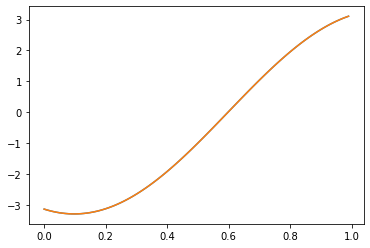

In [16]:
plt.plot(x,(u_e+p_e).cpu().detach().numpy())

In [17]:
u =  model_u(notes)
p =  model_p(notes)
r =  model_r(notes)
plt.plot(x,(r).cpu().detach().numpy())

NameError: name 'model_r' is not defined